In [1]:
cd .

/home/zackn/pysindy/examples


In [2]:
import importlib
import ZGN_PDE 

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid

import timeit
import os
import sys
from shutil import rmtree

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)
    
import pysindy as ps

from IPython.display import Video

# Seed the random number generators for reproducibility
np.random.seed(100)

## Import histogram data

In [3]:
dat=np.load('data/ensemble_histograms.npy')
nx,ny,nt=dat.shape
spatial_grid=np.load('data/ensemble_spatial_grid.npy')
t=np.load('data/ensemble_temporal_grid.npy')
L,vmax=spatial_grid[-1,-1]
dt=t[1]-t[0]

## Smooth with Gaussian kernel for differentiation and remove time pad

In [4]:
sigmax=10
sigmay=10
sigmat=10

kernelx=np.roll(np.exp(-(np.arange(nx)-nx/2)**2/(2*sigmax**2))/(2*np.pi*(sigmax/nx)**2)**0.5/nx,int(nx/2))
kernely=np.roll(np.exp(-(np.arange(ny)-ny/2)**2/(2*sigmay**2))/(2*np.pi*(sigmay/ny)**2)**0.5/ny,int(ny/2))
kernelt=np.roll(np.exp(-(np.arange(nt)-nt/2)**2/(2*sigmat**2))/(2*np.pi*(sigmat/nt)**2)**0.5/nt,int(nt/2))
kernel=np.einsum('i,j,k->ijk',kernelx,kernely,kernelt)

dat2=np.real(np.fft.ifftn(kernel*np.fft.fftn(dat)))

tpad=50
nt=nt-2*tpad
t=t[tpad:-tpad]-t[tpad]
U=np.zeros((nx,ny,nt,1))
U[:,:,:,0]=np.transpose(dat2[:,:,tpad:-tpad]*np.sum(dat[:,:,0])/np.sum(dat2[:,:,0]),axes=(1,0,2))
U_flat = np.reshape(U, (nx*ny*nt, 1))

print(U.shape)

(100, 100, 901, 1)


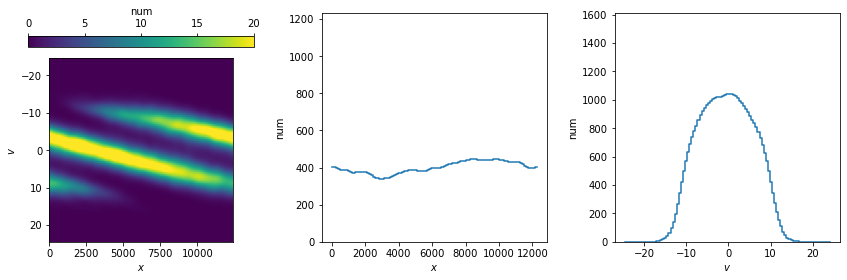

In [5]:
smoothhistograms=np.transpose(U[:,:,:,0],(2,0,1))
nmax=np.max(smoothhistograms)
nmaxv=np.max(np.sum(smoothhistograms,axis=1))
nmaxx=np.max(np.sum(smoothhistograms,axis=2))

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(smoothhistograms[i].T,vmin=0,vmax=20,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nx),np.sum(smoothhistograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(smoothhistograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

## Derivatives. After vectorizing, we speed up calculation by almost 50x

In [44]:
start=timeit.default_timer()
        
U_dot = ps.FiniteDifference(d=1,axis=-2)._differentiate(U, dt)
U_dot_flat = np.reshape(U_dot, (nx*ny*nt, 1))

UX=ps.FiniteDifference(d=1,axis=0)._differentiate(U, spatial_grid[:,0,0])
UXX=ps.FiniteDifference(d=2,axis=0)._differentiate(U, spatial_grid[:,0,0])
UP=ps.FiniteDifference(d=1,axis=1)._differentiate(U, spatial_grid[0,:,1])
UPP=ps.FiniteDifference(d=2,axis=1)._differentiate(U, spatial_grid[0,:,1])
UXP=ps.FiniteDifference(d=1,axis=0)._differentiate(UP, spatial_grid[:,0,0])

stop=timeit.default_timer()
print(stop-start)

0.4372183629311621


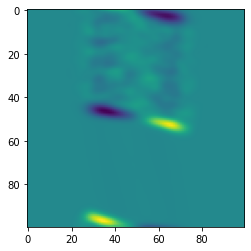

In [45]:
plt.imshow(U_dot[:,:,0,0])

In [7]:
start=timeit.default_timer()
uX=np.zeros((nx,ny,nt))
uXX=np.zeros((nx,ny,nt))
uP=np.zeros((nx,ny,nt))
uPP=np.zeros((nx,ny,nt))
uXP=np.zeros((nx,ny,nt))

for i in range(nt):
    for j in range(ny):
        uX[:, j, i] = ps.FiniteDifference(d=1,axis=0)._differentiate(U[:, j, i, :], spatial_grid[:, j, 0])[:,0]
        uXX[:, j, i] = ps.FiniteDifference(d=2,axis=0)._differentiate(U[:, j, i, :], spatial_grid[:, j, 0])[:,0]
    for j in range(nx):
        uP[j, :, i] = ps.FiniteDifference(d=1,axis=0)._differentiate(U[j, :, i, :], spatial_grid[j, :, 1])[:,0]
        uXP[j, :, i] = ps.FiniteDifference(d=1,axis=0)._differentiate(uX[j, :, i,np.newaxis], spatial_grid[j, :, 1])[:,0]
        uPP[j, :, i] = ps.FiniteDifference(d=2,axis=0)._differentiate(U[j, :, i, :], spatial_grid[j, :, 1])[:,0]
stop=timeit.default_timer()
print(stop-start)

21.42153867194429


In [9]:
print(np.linalg.norm(UX[:,:,:,0]-uX))
print(np.linalg.norm(UXX[:,:,:,0]-uXX))
print(np.linalg.norm(UP[:,:,:,0]-uP))
print(np.linalg.norm(UPP[:,:,:,0]-uPP))
print(np.linalg.norm(UXP[:,:,:,0]-uXP))

0.0
0.0
0.0
0.0
7.90146167483481e-15


## pysindy with smoothed derivatives

In [49]:
importlib.reload(ps.feature_library.pde_library)
importlib.reload(ps.feature_library.base)
importlib.reload(ps.feature_library)
importlib.reload(ps)

start=timeit.default_timer()

P=np.zeros((nx,ny,nt))
P[:]=spatial_grid[:,:,1][:,:,np.newaxis]
P=P.reshape((nx*ny*nt))

space_functions = [lambda: P, lambda: P**2, lambda: U_flat[:,0], lambda: U_flat[:,0]**2, lambda: P*U_flat[:,0] ]
space_function_names = [lambda: 'p', lambda: 'p^2', lambda: 'u', lambda: 'u^2', lambda: 'up' ]
space_lib=ps.CustomLibrary(library_functions=space_functions,function_names=space_function_names,include_bias=True)

library_functions = []
library_function_names = []
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=t, include_bias=True, 
                        is_uniform=True)

combined_lib=space_lib*pde_lib

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-1, normalize_columns=False, max_iter=100)
model = ps.SINDy(feature_library=combined_lib, optimizer=optimizer, feature_names=['u'])
model.fit(U_flat,x_dot=U_dot_flat)
model.print()

stop=timeit.default_timer()
print(stop-start)

(u)' = -0.240 1 u_[1 0] + -1.740 1 u_[1 1] + -0.982 p u_[1 0] + -2.744 p^2 u_[2 0] + 32.567 u u_[2 0] + -1.280 u^2 u_[2 0]
16.608062235172838


In [54]:
start=timeit.default_timer()

test1=pde_lib.fit(U_flat).transform(U_flat)
test2=space_lib.fit(U_flat).transform(U_flat)
test3=np.reshape(test1[:,:,np.newaxis]*test2[:,np.newaxis,:],(test1.shape[0],test1.shape[1]*test2.shape[1]))

stop=timeit.default_timer()
print(stop-start)

2.2900701388716698


In [55]:
start=timeit.default_timer()
test=combined_lib.fit(U_flat).transform(U_flat)
stop=timeit.default_timer()
print(stop-start)

4.3404739601537585


##  Sam's PDE_find with tensor product library and finite-difference derivatives

In [10]:
importlib.reload(ZGN_PDE)
start=timeit.default_timer()

spacefeatures = np.hstack([np.ones((nx*ny*nt,1)),
                      np.reshape(P, (nx*ny*nt,1)),
                      np.reshape(P**2, (nx*ny*nt,1)),
                      np.reshape(U, (nx*ny*nt,1)),  
                      np.reshape(U**2, (nx*ny*nt,1)), 
                      np.reshape(U, (nx*ny*nt,1))*np.reshape(P, (nx*ny*nt,1))])
spacefeaturenames=['','p','p^2','u','u^2','up']
derivativefeatures = np.hstack([np.ones((nx*ny*nt,1)),
                      np.reshape(UX,(nx*ny*nt,1)),
                      np.reshape(UP,(nx*ny*nt,1)),
                      np.reshape(UXX,(nx*ny*nt,1)),
                      np.reshape(UXP,(nx*ny*nt,1)),
                      np.reshape(UPP,(nx*ny*nt,1))])

derivativefeaturenames=['','ux','up','uxx','uxp','upp']
tensorfeatures=np.reshape(spacefeatures[:,:,np.newaxis]*derivativefeatures[:,np.newaxis,:],(nx*ny*nt,36))
tensorfeaturenames=[]
ind=0
for i in range(6):
    for j in range(6):
        tensorfeaturenames=tensorfeaturenames+[spacefeaturenames[i]+'  '+derivativefeaturenames[j]]
        ind=ind+1

        
ws=ZGN_PDE.STRidge(tensorfeatures, U_dot_flat, 1e-2, 100, 0.1, normalize = 0, print_results = True)
ZGN_PDE.print_pde(ws[-1],tensorfeaturenames)

stop=timeit.default_timer()
print(stop-start)

iter, terms: 0 36
iter, terms: 1 6
iter, terms: 2 5
u_t = (-0.241022 +0.000000i)  ux
    + (-1.814007 +0.000000i)  uxp
    + (-0.982634 +0.000000i)p  ux
    + (-1.350011 +0.000000i)p^2  uxx
    + (0.209269 +0.000000i)u^2  uxx
   
5.016373605001718


##  Sam's PDE_find with tensor product library and finite difference derivatives

In [21]:
start=timeit.default_timer()
uX=np.zeros((nx,ny,nt))
uXX=np.zeros((nx,ny,nt))
uP=np.zeros((nx,ny,nt))
uPP=np.zeros((nx,ny,nt))
uXP=np.zeros((nx,ny,nt))
#If these were vectorized, they would be faster.
#implement an axis option for ps.FiniteDifference to allow vectorization.
for i in range(nt):
    for j in range(ny):
        uX[:, j, i] = ps.FiniteDifference(d=1)._differentiate(U[:, j, i, :], spatial_grid[:, j, 0])[:,0]
        uXX[:, j, i] = ps.FiniteDifference(d=2)._differentiate(U[:, j, i, :], spatial_grid[:, j, 0])[:,0]
    for j in range(nx):
        uP[j, :, i] = ps.FiniteDifference(d=1)._differentiate(U[j, :, i, :], spatial_grid[j, :, 1])[:,0]
        uXP[j, :, i] = ps.FiniteDifference(d=1)._differentiate(uX[j, :, i,np.newaxis], spatial_grid[j, :, 1])[:,0]
        uPP[j, :, i] = ps.FiniteDifference(d=2)._differentiate(U[j, :, i, :], spatial_grid[j, :, 1])[:,0]

spacefeatures = np.hstack([np.ones((nx*ny*nt,1)),
                      np.reshape(P, (nx*ny*nt,1)),
                      np.reshape(P**2, (nx*ny*nt,1)),
                      np.reshape(U, (nx*ny*nt,1)),  
                      np.reshape(U**2, (nx*ny*nt,1)), 
                      np.reshape(U, (nx*ny*nt,1))*np.reshape(P, (nx*ny*nt,1))])
spacefeaturenames=['','p','p^2','u','u^2','up']
derivativefeatures = np.hstack([np.ones((nx*ny*nt,1)),
                      np.reshape(uX,(nx*ny*nt,1)),
                      np.reshape(uP,(nx*ny*nt,1)),
                      np.reshape(uXX,(nx*ny*nt,1)),
                      np.reshape(uXP,(nx*ny*nt,1)),
                      np.reshape(uPP,(nx*ny*nt,1))])

derivativefeaturenames=['','ux','up','uxx','uxp','upp']
tensorfeatures=np.reshape(spacefeatures[:,:,np.newaxis]*derivativefeatures[:,np.newaxis,:],(nx*ny*nt,36))
tensorfeaturenames=[]
ind=0
for i in range(6):
    for j in range(6):
        tensorfeaturenames=tensorfeaturenames+[spacefeaturenames[i]+'  '+derivativefeaturenames[j]]
        ind=ind+1

        
ws=ZGN_PDE.STRidge(tensorfeatures, U_dot_flat, 1e-2, 100, 0.1, normalize = 0, print_results = True)
ZGN_PDE.print_pde(ws[-1],tensorfeaturenames)

        
stop=timeit.default_timer()
print(stop-start)

iter, terms: 0 36
iter, terms: 1 6
iter, terms: 2 5
u_t = (-0.241022 +0.000000i)  ux
    + (-1.814007 +0.000000i)  uxp
    + (-0.982634 +0.000000i)p  ux
    + (-1.350011 +0.000000i)p^2  uxx
    + (0.209269 +0.000000i)u^2  uxx
   
18.205755134578794


In [22]:
print(np.linalg.norm(uX[:,:,0]-np.real(UX[:,:,0]))/np.linalg.norm(np.real(UX[:,:,0])))
print(np.linalg.norm(uP[:,:,0]-np.real(UP[:,:,0]))/np.linalg.norm(np.real(UP[:,:,0])))
print(np.linalg.norm(uXX[:,:,0]-np.real(UXX[:,:,0]))/np.linalg.norm(np.real(UXX[:,:,0])))
print(np.linalg.norm(uPP[:,:,0]-np.real(UPP[:,:,0]))/np.linalg.norm(np.real(UPP[:,:,0])))
print(np.linalg.norm(uXP[:,:,0]-np.real(UXP[:,:,0]))/np.linalg.norm(np.real(UXP[:,:,0])))

0.05059402093150143
0.026703562583384705
0.1823092058269508
0.05536806596577111
0.11060881943572957


## The ridge_regression in pysindy and the leastsq in Sam's code are almost identical, and the final result after leastsq unbiasing is identical, but pysindy and Sam seem to do the thresholding and optimization in reverse order.

In [23]:
start=timeit.default_timer()

testfeatures=combined_lib.transform(U_flat)
ws=ZGN_PDE.STRidge(testfeatures, U_dot_flat, 1e-1, 100, 0.1, normalize = 0, print_results = True)
ZGN_PDE.print_pde(ws[-1],tensorfeaturenames)
print((np.ravel(optimizer.history_[0])-np.ravel(np.array(ws[0])))/np.ravel(np.array(ws[0])))
print(np.ravel(ws[-1])-np.ravel(optimizer.coef_))
stop=timeit.default_timer()
print(stop-start)

iter, terms: 0 36
iter, terms: 1 7
iter, terms: 2 6
u_t = (-0.239837 +0.000000i)  ux
    + (-1.739592 +0.000000i)  uxp
    + (-0.981895 +0.000000i)p  ux
    + (-2.743684 +0.000000i)p^2  uxx
    + (32.566819 +0.000000i)u  uxx
    + (-1.280224 +0.000000i)u^2  uxx
   
[-1.05731951e-06  1.15878709e-05 -8.80689511e-04  2.09712081e-02
  3.29385685e-05 -4.60707770e-06  1.04245172e-06  1.35437924e-07
  9.36800926e-07  1.75028417e-03  5.34299499e-06  1.44790608e-05
 -1.64600799e-06  7.42166999e-05 -1.05828059e-05  3.29872689e-05
  9.52297245e-06 -3.33438122e-06  3.21019964e-08 -1.53596550e-03
  1.04531658e-04  8.49636471e-05 -9.59845587e-06 -6.70865916e-06
  9.52463672e-08  2.50033077e-04  3.09091605e-05  4.48339393e-06
 -1.30116506e-05 -7.01782884e-06 -4.05036055e-06 -3.33742002e-06
 -2.67603270e-06 -6.81414276e-05 -1.32387908e-07  2.57235237e-05]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
32.893617569003254


In [24]:
print(np.ravel(ws[-4])-np.ravel(optimizer.history_[-4]))
print(np.ravel(ws[-4])-np.ravel(optimizer.history_[-3]))
print(np.ravel(ws[-3])-np.ravel(optimizer.history_[-2]))
print(np.ravel(ws[-2])-np.ravel(optimizer.history_[-1]))
print(np.ravel(ws[-1])-np.ravel(optimizer.coef_))

[ 5.03288151e-10  3.08980320e-06  5.05269996e-09  3.64245621e-04
  1.74845641e-05  2.73918569e-08  9.51889447e-13  1.40163649e-07
  1.67720891e-10 -1.05781971e-05 -5.23920427e-08  1.14719760e-10
 -1.35826180e-12 -1.41760767e-08 -1.42222375e-11  1.75600224e-05
 -4.01174448e-08 -1.01493996e-10  5.49073573e-11 -4.04130308e-07
 -6.47383935e-10 -2.03518812e-05 -1.89276091e-06 -2.87095599e-09
 -8.51899477e-12  1.28762980e-08  2.00470740e-11 -7.37216913e-07
  5.33850225e-08  7.97714904e-11 -3.75237671e-12 -1.50259615e-08
 -2.01063258e-11  2.13216747e-06 -5.54620489e-11 -9.69883533e-12]
[ 4.76003846e-04  3.08980320e-06  5.73720920e-06 -1.73688430e-02
  1.74845641e-05  5.94560342e-03 -9.13125690e-07  1.40163649e-07
 -1.79035786e-04  6.04370267e-03  9.80574431e-03 -7.92314926e-06
 -8.25185422e-07  1.91009257e-04 -1.34390044e-06  1.75600224e-05
  4.21270197e-03 -3.04386299e-05 -1.71040320e-03 -2.63111579e-04
  6.19318536e-06 -2.03518812e-05 -1.89276091e-06 -4.27947809e-04
  8.94416765e-05 -5.1498

## compare time required to take derivatives

In [25]:
start=timeit.default_timer()

testpdefeatures=pde_lib.transform(U_flat)

stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()

uX=np.zeros((nx,ny,nt))
uXX=np.zeros((nx,ny,nt))
uP=np.zeros((nx,ny,nt))
uPP=np.zeros((nx,ny,nt))
uXP=np.zeros((nx,ny,nt))
#If these were vectorized, they would be faster.
#implement an axis option for ps.FiniteDifference to allow vectorization.
for i in range(nt):
    for j in range(ny):
        uX[:, j, i] = ps.FiniteDifference(d=1)._differentiate(U[:, j, i, :], spatial_grid[:, j, 0])[:,0]
        uXX[:, j, i] = ps.FiniteDifference(d=2)._differentiate(U[:, j, i, :], spatial_grid[:, j, 0])[:,0]
    for j in range(nx):
        uP[j, :, i] = ps.FiniteDifference(d=1)._differentiate(U[j, :, i, :], spatial_grid[j, :, 1])[:,0]
        uXP[j, :, i] = ps.FiniteDifference(d=1)._differentiate(uX[j, :, i,np.newaxis], spatial_grid[j, :, 1])[:,0]
        uPP[j, :, i] = ps.FiniteDifference(d=2)._differentiate(U[j, :, i, :], spatial_grid[j, :, 1])[:,0]
stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()

UX=ZGN_PDE.SpectralDiff(U[:,:,:,0],L/nx,axis=0,order=1) 
UXX=ZGN_PDE.SpectralDiff(U[:,:,:,0],L/nx,axis=0,order=2) 
UP=ZGN_PDE.SpectralDiff(U[:,:,:,0],2*vmax/ny,axis=1,order=1) 
UPP=ZGN_PDE.SpectralDiff(U[:,:,:,0],2*vmax/ny,axis=1,order=2) 
UXP=ZGN_PDE.SpectralDiff(ZGN_PDE.SpectralDiff(U[:,:,:,0],2*vmax/ny,axis=1,order=1),L/nx,axis=0,order=1)
stop=timeit.default_timer()
print(stop-start)

12.628323973156512
12.762375810183585
1.4460869557224214


## compare time for tensor products

In [26]:
importlib.reload(ps)
start=timeit.default_timer()

testfeatures2=combined_lib.transform(U_flat)

stop=timeit.default_timer()
print(stop-start)

start=timeit.default_timer()

testpdefeatures=pde_lib.transform(U_flat)
testspacefeatures=space_lib.transform(U_flat)
testfeatures=np.reshape(testspacefeatures[:,:,np.newaxis]*testpdefeatures[:,np.newaxis,:],(nx*ny*nt,36))

stop=timeit.default_timer()
print(stop-start)

27.709119267296046
14.079364432953298


## My optimal implementation is about 8x faster

In [27]:
start=timeit.default_timer()

UX=ZGN_PDE.SpectralDiff(U[:,:,:,0],L/nx,axis=0,order=1) 
UXX=ZGN_PDE.SpectralDiff(U[:,:,:,0],L/nx,axis=0,order=2) 
UP=ZGN_PDE.SpectralDiff(U[:,:,:,0],2*vmax/ny,axis=1,order=1) 
UPP=ZGN_PDE.SpectralDiff(U[:,:,:,0],2*vmax/ny,axis=1,order=2) 
UXP=ZGN_PDE.SpectralDiff(ZGN_PDE.SpectralDiff(U[:,:,:,0],2*vmax/ny,axis=1,order=1),L/nx,axis=0,order=1)

spacefeatures = np.hstack([np.ones((nx*ny*nt,1)),
                      np.reshape(P, (nx*ny*nt,1)),
                      np.reshape(P**2, (nx*ny*nt,1)),
                      np.reshape(U, (nx*ny*nt,1)),  
                      np.reshape(U**2, (nx*ny*nt,1)), 
                      np.reshape(U, (nx*ny*nt,1))*np.reshape(P, (nx*ny*nt,1))])
spacefeaturenames=['','p','p^2','u','u^2','up']
derivativefeatures = np.hstack([np.ones((nx*ny*nt,1)),
                      np.reshape(UX,(nx*ny*nt,1)),
                      np.reshape(UP,(nx*ny*nt,1)),
                      np.reshape(UXX,(nx*ny*nt,1)),
                      np.reshape(UXP,(nx*ny*nt,1)),
                      np.reshape(UPP,(nx*ny*nt,1))])

derivativefeaturenames=['','ux','up','uxx','uxp','upp']
tensorfeatures=np.reshape(spacefeatures[:,:,np.newaxis]*derivativefeatures[:,np.newaxis,:],(nx*ny*nt,36))
tensorfeaturenames=[]
ind=0
for i in range(6):
    for j in range(6):
        tensorfeaturenames=tensorfeaturenames+[spacefeaturenames[i]+'  '+derivativefeaturenames[j]]
        ind=ind+1
        
stop=timeit.default_timer()
print(stop-start)

4.023269337136298


## Test my pde_library implementation

In [62]:
x=U_flat

num_derivatives = 0
derivative_order=2
include_interaction=True
include_bias=True
functions=[lambda:np.ones(n_samples), lambda x:x]


#init
n_samples, n_features = x.shape

dims=spatial_grid.shape[:-1]
ndim=len(dims)
num_time = n_samples // np.product(dims)

#list of derivatives
indices=()
for i in range(0,ndim):
    indices=indices+(np.arange(derivative_order+1),)
        
multiindices=[]
for ind in product(*indices):
    current=np.array(ind)
    if(np.sum(ind)>0 and np.sum(ind)<=derivative_order):
        multiindices.append(current)
multiindices=np.array(multiindices)
num_derivatives=len(multiindices)

In [63]:
from itertools import combinations, product

#fit
#number of output features
# Count the number of non-derivative terms
n_output_features=0
for f in functions:
    n_args = f.__code__.co_argcount
    n_output_features += len(
        list(combinations(range(n_features), n_args))
    )

# Add the mixed derivative library_terms
if include_interaction:
    n_output_features += (
        n_output_features * n_features * num_derivatives
    )
# Add the pure derivative library terms
n_output_features += n_features * num_derivatives

# If there is a constant term, add 1 to n_output_features
if include_bias:
    n_output_features += 1

print(n_output_features)

18


In [64]:
start=timeit.default_timer()
#transform
xp=np.zeros((n_samples,n_output_features))

# derivative terms
library_derivatives = np.zeros((n_samples, n_features*num_derivatives), dtype=x.dtype)
library_idx = 0

for multiindex in multiindices:
    derivs=np.reshape(x,np.concatenate([dims,[num_time],[n_features]]))
    for axis in range(ndim):
        if(multiindex[axis]>0):
            s = [0 for dim in spatial_grid.shape]
            s[axis]=slice(dims[axis])
            s[-1]=axis
            derivs=ps.FiniteDifference(d=multiindex[axis],axis=axis)._differentiate(derivs,spatial_grid[tuple(s)])
    library_derivatives[:,library_idx:library_idx+n_features]=np.reshape(derivs,(n_samples,n_features))
    library_idx += n_features

# library function terms
n_library_terms=0
for f in functions:
    for c in combinations(np.arange(n_features), f.__code__.co_argcount):
        n_library_terms += 1
        
library_functions=np.zeros((n_samples,n_library_terms))
library_idx=0
for f in functions:
    for c in combinations(np.arange(n_features), f.__code__.co_argcount):
        library_functions[:, library_idx] = np.reshape(f(*[x[:, j] for j in c]),(n_samples))
        library_idx += 1
        
library_idx=0
#constant term
if include_bias:
    xp[:,library_idx] = np.ones(n_samples)
    library_idx += 1
#library function terms
xp[:,library_idx:library_idx+len(functions)]=library_functions
library_idx += len(functions)
#pure derivative terms
xp[:,library_idx:library_idx+num_derivatives]=library_derivatives
library_idx += num_derivatives
#mixed function derivative terms
xp[:,library_idx:library_idx+len(functions)*num_derivatives]=np.reshape(library_functions[:,:,np.newaxis]*library_derivatives[:,np.newaxis,:],(n_samples,len(functions)*num_derivatives))
library_idx += len(functions)*num_derivatives

stop=timeit.default_timer()
print(stop-start)

1.990526779089123


##  Weak-form sindy

In [9]:
K=50
Hx=L/20
Hy=vmax/20
Ht=10
library_functions = [lambda x: x, lambda x: x * x ]
library_function_names = [lambda x: x, lambda x: x + '^2']
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names, 
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=t, include_bias=True, K=K, Hx=Hx, Hy=Hy, Ht=Ht,
                        is_uniform=True, weak_form=True, num_pts_per_domain=30)
P=np.zeros((nx,ny,nt))
P[:]=spatial_grid[:,:,1][:,:,np.newaxis]
P=P.reshape((nx*ny*nt))
def p_var():
    return P

space_lib=ps.CustomLibrary(library_functions=[p_var],function_names=[lambda: 'p'])
library_functions = [lambda x: x, lambda x: x * x ]
library_function_names = [lambda x: x, lambda x: x + '^2']
pde_lib = ps.PDELibrary(library_functions=library_functions, 
                        function_names=library_function_names,
                        derivative_order=2, spatial_grid=spatial_grid,
                        temporal_grid=t, include_bias=True, K=K, Hx=Hx, Hy=Hy, Ht=Ht,
                        is_uniform=True, weak_form=True, num_pts_per_domain=30)
combined_lib=pde_lib*space_lib
optimizer = ps.STLSQ(threshold=0.1, alpha=1e-3, normalize_columns=False, max_iter=100)
model = ps.SINDy(feature_library=combined_lib, optimizer=optimizer,feature_names=['u'])
start=timeit.default_timer()
model.fit(U_flat[:,0])
model.print()

In [10]:
# Convert u_dot into a weak form using the pre-defined pde_lib
def convert_u_dot_2D(u, t, pde_lib):  # For weak form 2D PDES
    K = pde_lib.K  
    num_pts_per_domain = pde_lib.num_pts_per_domain
    x = pde_lib.spatial_grid
    u_dot_integral = np.zeros((K, u.shape[-1]))
    for j in range(u.shape[-1]):
        # Define interpolation object to interpolate u(x, y, t) onto the grid
        # spanned by X, Y, t
        u_interp = RegularGridInterpolator((pde_lib.spatial_grid[:, 0, 0], 
                                            pde_lib.spatial_grid[0, :, 1],
                                            t), 
                                           u[:, :, :, j])
        for k in range(K):
            X = np.ravel(pde_lib.X[k, :, :, :])
            Y = np.ravel(pde_lib.Y[k, :, :, :])
            tgrid = np.ravel(pde_lib.t[k, :, :, :])
            XYt = np.array((X, Y, tgrid)).T
            # Interpolate u onto the kth subdomain
            u_new = u_interp(XYt)
            u_new = np.reshape(u_new, (num_pts_per_domain,
                                       num_pts_per_domain,
                                       num_pts_per_domain,
                                       1))
            # Get the smooth weights on the kth subdomain
            w_diff = pde_lib._smooth_ppoly(
                        np.transpose((pde_lib.xgrid_k[k, :], pde_lib.ygrid_k[k, :])),
                        pde_lib.tgrid_k[k, :], k, 0, 0, 0, 1
                    )
            # Integrate over x, y, t points in the kth subdomain
            u_dot_integral[k, j] = (-1) * (
                trapezoid(
                    trapezoid(
                        trapezoid(
                            u_new * w_diff, 
                            x=pde_lib.xgrid_k[k, :], 
                            axis=0
                        ),
                        x=pde_lib.ygrid_k[k, :],
                        axis=0
                    ),
                    x=pde_lib.tgrid_k[k, :], 
                    axis=0
                )
            )
    return u_dot_integral

In [11]:
U_dot_integral = convert_u_dot_2D(U, t, pde_lib)
U_flat = np.reshape(U, (nx*ny*nt, 3))

optimizer = ps.STLSQ(threshold=0.1, alpha=1e-3, normalize_columns=False, max_iter=100)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer,feature_names=['u','p'])

In [12]:
#Fit with the momentum but no position
start=timeit.default_timer()
model.fit(U_flat[:,:2], x_dot=U_dot_integral[:,:2])
model.print()
stop=timeit.default_timer()
print(stop-start)

(u)' = -0.143 u_1 + -0.853 up_1
(p)' = 0.000
51.725565775996074


/home/zackn/manybody/pysindy/optimizers/stlsq.py:174: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(
/home/zackn/manybody/pysindy/optimizers/stlsq.py:174: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


##  Integrate collisionless Boltzmann with pseudospectral

In [13]:
u0=U[:,:,0,0]

def dudt(t, u, x, p):
    nx=len(x)
    ny=len(p)
    ux = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),L/nx,axis=0,order=1) 
    up = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),2*vmax/ny,axis=1,order=1) 
    return np.reshape(-p*np.real(ux),(nx*ny))

mmax=len(t)-1
tmax=t[mmax]
dt=t[1]-t[0]
start=timeit.default_timer()
sol=solve_ivp(dudt,[0,tmax],np.reshape(u0,(nx*ny)), method='LSODA', args=[np.arange(0,L,L/nx),np.arange(-vmax,vmax,2*vmax/ny)], t_eval=t[:mmax+1],rtol=1e-8,atol=1e-8)
stop=timeit.default_timer()
print(stop-start)

1.7777039369975682


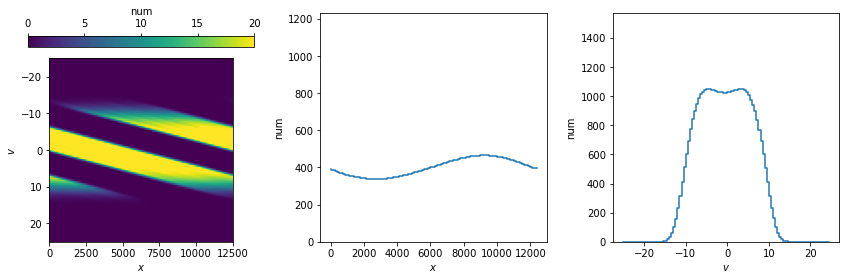

In [14]:
histograms=np.transpose(np.reshape(sol.y,(nx,ny,mmax+1)),(2,0,1))
nmax=np.max(histograms)
nmaxv=np.max(np.sum(histograms,axis=1))
nmaxx=np.max(np.sum(histograms,axis=2))

i=-1
plt.subplots(1,3,f(x0)' = -0.238 x0_11 + -1.000 x0_1p + -770.352 x0_111 + -6.097 x0_11p + -0.077 x0_11p^2 + -4.179 x0_121 + 21.885 x0x0_111 + 0.586 x0x0_11pigsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(histograms[i].T,vmin=0,vmax=20,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nx),np.sum(histograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(histograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

## integrate sindy model with pseudospectral

In [37]:
coeffs=np.real(w[np.nonzero(np.real(w))[0]])
u0=U[:,:,0,0]

def dudt(t, u, x, p):
    nx=len(x)
    ny=len(p)
    ux = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),L/nx,axis=0,order=1) 
    uxx = ZGN_PDE.SpectralDiff(u.reshape((nx,ny)),L/nx,axis=0,order=2) 
    return np.reshape((coeffs[0]+coeffs[1]*p)*np.real(ux)+(coeffs[2]*p**2+coeffs[3]*u.reshape((nx,ny))*p+coeffs[4]*u.reshape((nx,ny))**2)*np.real(uxx),(nx*ny))

mmax=len(t)-1
tmax=t[mmax]
dt=t[1]-t[0]
start=timeit.default_timer()
bsol=solve_ivp(dudt,[0,tmax],np.reshape(u0,(nx*ny)), method='BDF', args=[np.arange(0,L,L/nx),np.arange(-vmax,vmax,2*vmax/ny)], t_eval=t[:mmax+1],rtol=1e-8,atol=1e-8)
stop=timeit.default_timer()
print(stop-start)

192.53007688300568


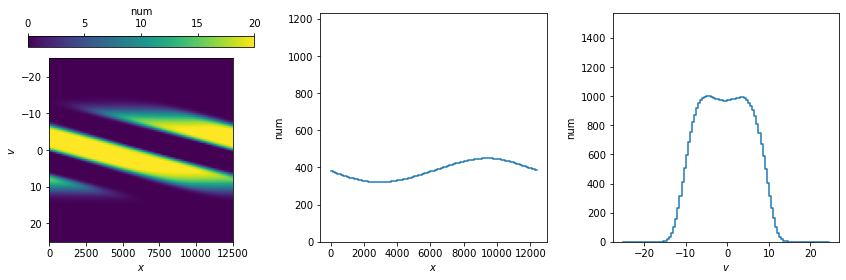

In [38]:
bhistograms=np.transpose(np.reshape(bsol.y,(nx,ny,mmax+1)),(2,0,1))
nmax=np.max(histograms)
nmaxv=np.max(np.sum(histograms,axis=1))
nmaxx=np.max(np.sum(histograms,axis=2))

i=-1
plt.subplots(1,3,figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(bhistograms[i].T,vmin=0,vmax=20,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
plt.colorbar(label='num',location='top')
plt.xlabel('$x$')
plt.ylabel('$v$')
plt.subplot(1,3,2)
plt.step(np.arange(0,L,L/nx),np.sum(bhistograms[i],axis=1))
plt.xlabel('$x$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxx)
plt.subplot(1,3,3)
plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(bhistograms[i],axis=0))
plt.xlabel('$v$')
plt.ylabel('num')
plt.ylim(0,1.5*nmaxv)
plt.tight_layout()
plt.show()

## Compare results

In [20]:
filebase='data/sindyfit'
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
start=timeit.default_timer()
for i in range(0,len(t),skip):
    print(i, len(t),end='\r')
    plt.subplots(3,3,figsize=(10,10))
    plt.subplot(3,3,1)
    plt.imshow(smoothhistograms[i].T,vmin=0,vmax=50,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(3,3,2)
    plt.step(np.arange(0,L,L/nx),np.sum(smoothhistograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(3,3,3)
    plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(smoothhistograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    
    plt.subplot(3,3,4)
    plt.imshow(histograms[i].T,vmin=0,vmax=50,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(3,3,5)
    plt.step(np.arange(0,L,L/nx),np.sum(histograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(3,3,6)
    plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(histograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    
    plt.subplot(3,3,7)
    plt.imshow(bhistograms[i].T,vmin=0,vmax=50,extent=(0,L,vmax,-vmax),aspect=L/(2*vmax))
    plt.colorbar(label='num',location='top')
    plt.xlabel('$x$')
    plt.ylabel('$v$')
    plt.subplot(3,3,8)
    plt.step(np.arange(0,L,L/nx),np.sum(bhistograms[i],axis=1))
    plt.xlabel('$x$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxx)
    plt.subplot(3,3,9)
    plt.step(np.arange(-vmax,vmax,2*vmax/ny),np.sum(bhistograms[i],axis=0))
    plt.xlabel('$v$')
    plt.ylabel('num')
    plt.ylim(0,1.5*nmaxv)
    plt.tight_layout()
    plt.savefig(filebase+'animation/'+str(int(i/skip)).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 30 ')
rmtree(filebase+'animation')

stop=timeit.default_timer()
print(stop-start)

1099.970664018765


In [21]:
filebase='data/sindyfit'

Video(filebase+'animation.mp4',width=800)